In [5]:
import spacy
from spacy import displacy
import visualise_spacy_tree
from IPython.display import Image

## Create model

In [132]:
my_file = open("drugs list.txt", "r", encoding='utf-8')
my_file = my_file.readlines()
drugs_list = []
for i in my_file:
    drugs_list.append(i.replace('\n', ''))

my_file = open("countries list.txt", "r", encoding='utf-8')
my_file = my_file.readlines()
countries_list = []
for i in my_file:
    countries_list.append(i.replace('\n', ''))
        

In [133]:
def configure_spacy_model():
    # Create dict of drug pattern and quantity pattern
    pattern_list = []
    
    drugs_ent_list = []
    for i in drugs_list:
        pattern_list.append({"label": "DRUG", "pattern": [{"lower": i}]})
    
    quantity_rule = {"label": "QUANTITY", "pattern": [{"IS_DIGIT": True}, {"LOWER": "gram"}]}
    pattern_list.append(quantity_rule)
    
    for i in countries_list:
        pattern_list.append({"label": "GPE", "pattern": [{"lower": i.replace(' ', '').lower()}]})
    
    # Add drug and quantity rules to the model
    config = {
   "phrase_matcher_attr": None,
   "validate": True,
   "overwrite_ents": True,
   "ent_id_sep": "||",
    }
    ruler = nlp.add_pipe("entity_ruler", config=config)

    #List of Entities and Patterns
#     patterns = drugs_ent_list
    ruler.add_patterns(pattern_list)


In [134]:
import spacy
from spacy import displacy
# !python -m spacy download nl_core_news_md
nlp = spacy.load('nl_core_news_md')
configure_spacy_model()

In [135]:
def get_chunks(ecli):
    parsed_id = ecli.replace(':', '-')
    selected_case = merged_df[merged_df['id'] == parsed_id].iloc[0]
    case_text = selected_case['case text']
    split_case_text = re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])|\n', case_text)
    
    relevant_chunks = []
    for i in split_case_text:
        if any(drug in i for drug in drugs_list):
            corrected_chunk = fix_countries(i)
            relevant_chunks.append(corrected_chunk)
    return relevant_chunks

In [154]:
def extract_chunk_info(txt):
    source_country = None
    total_info = []
    for token in nlp(txt):
        info = {}
        drug_info = {}
        countries = []
        
        if token.ent_type_ == "DRUG":
            info = {"drug": token.text}
            
            ## Get source and destination
            for ancestor in token.ancestors:
                for nephew in ancestor.children:
                    if nephew.ent_type_ == "GPE" or nephew.ent_type_ == "LOC":
                        countries.append(nephew)
                        for child in nephew.children:
                            if child.dep_ == "conj" and child.ent_type_ == "GPE" or child.ent_type_ == "LOC":
                                countries.append(child.text)
                            elif child.pos_ == "ADP" and child.dep_ == "case":
                                adj = child.text
            if len(countries) > 0 :
                try:
                    info[adj] = countries
                except:
                    info['land'] = countries
            
            ##### After adding cocainetransporten as a drug, children can be countries too.
            countries = []
            for child in token.children:
                if child.ent_type_ == "GPE" or nephew.ent_type_ == "LOC":
                    countries.append(child)
                    for grandchild in child.children:
                        if grandchild.pos_ == "ADP" and grandchild.dep_ == "case":
                            adj = grandchild.text
            
            if len(countries) > 0 :
                try:
                    info[adj] = countries
                except:
                    info['land'] = countries
            ###############################################
                
            
                 
            ## Get volume
            for ancestors in token.ancestors:
                for nephew in ancestors.children:
                    if nephew.ent_type_ == "QUANTITY" or nephew.ent_type_ == "CARDINAL":
                        for second_nephew in nephew.children:
                            if second_nephew.is_digit != nephew.is_digit:
                                if second_nephew.is_digit:
                                    info['volume'] = second_nephew.text
                                    info['volume_type'] = nephew.text
                                else:
                                    info['volume'] = nephew.text
                                    info['volume_type'] = second_nephew.text
            if 'volume' not in info:
                for child in token.children:
                    if (child.dep_ == "det" and child.like_num) or (child.dep_ == "nummod"):
                        info['volume'] = child.text
                                
        if len(info) > 0:
#             print(info)
            total_info.append(info)
    return total_info

In [187]:
def extract_chunk_info2(txt):
    for token in nlp(txt):
        info = {}
        drug_info = {}
        countries = []
        
        if token.ent_type_ == "DRUG":
            info = {"drug": token.text}
            print(token.text)


## b

In [184]:
txtcol = []
txtcol.append('Het Gerecht neemt op dit onderdeel mede in aanmerking dat het uiterst onwaarschijnlijk is dat derden die zoveel cocaïne naar Sint Maarten willen smokkelen daarvoor een manier kiezen die het uiterst onzeker maakt of de cocaïne uiteindelijk wel wordt meegenomen en afgegeven. ')
txtcol.append('- met elkaar en/of met een of meer anderen (verblijvende in Nederland en/of Brazilië) afspraken heeft/hebben gemaakt voor het vervoer van die/een hoeveelheid cocaïne door M. S. vanuit Brazilië naar Nederland en/of (daartoe)')
txtcol.append('- met elkaar en/of met een of meer anderen (verblijvende in Nederland en/of Argentinië en/of Brazilië) afspraken heeft/hebben gemaakt voor het vervoer van die/een hoeveelheid cocaïne door D. S. vanuit Argentinië en/of Brazilië naar Nederland en/of (daartoe)')
txtcol.append('- met elkaar en/of met een of meer anderen (verblijvende in Nederland en/of Argentinië en/of Brazilië) afspraken gemaakt voor het vervoer van die/een hoeveelheid cocaïne door D. S. vanuit Argentinië en/of Brazilië naar Nederland en/of (daartoe)')
txtcol.append('Verdachte heeft zich, samen met anderen, schuldig gemaakt aan meerdere cocaïnetransporten vanuit Zuid-Amerika.')
txtcol.append('''hij op of omstreeks 16 april 2014 te Eindhoven opzettelijk buiten het grondgebied van Nederland heeft gebracht, als bedoeld in artikel 1 lid 5 van de Opiumwet, ongeveer 56.702 pillen, in elk geval een hoeveelheid van een materiaal bevattende MDMA, zijnde MDMA een middel als bedoeld in de bij die wet behorende lijst I, dan wel aangewezen krachtens het vijfde lid van artikel 3a van die wet, immers heeft verdachte opzettelijk twee, althans een, koffer(s), waarin die pillen (telkens) heimelijk in de bodem waren verstopt, op de luchthaven aldaar aangeboden aan de beveiliging en/of douane ter inklaring voor een vlucht naar Portugal;''')
txtcol.append('zij op 14 februari 2016 te Schiphol, gemeente Haarlemmermeer, opzettelijk binnen het grondgebied van Nederland heeft gebracht een hoeveelheid van een materiaal bevattende cocaïne.')


In [188]:
num = 0
for i in txtcol:
    txt = fix_countries(i)
    print(num)
    extract_chunk_info2(txt)
    num += 1

0
cocaïne
cocaïne
1
cocaïne
2
cocaïne
3
cocaïne
4
cocaïnetransporten
5
MDMA
MDMA
6
cocaïne


In [164]:
for i in txtcol:
    txt = fix_countries(i)
    print(extract_chunk_info(txt))


[{'drug': 'cocaïne', 'naar': [SintMaarten], 'volume': 'zoveel'}, {'drug': 'cocaïne'}]
[{'drug': 'cocaïne'}]
[{'drug': 'cocaïne'}]
[{'drug': 'cocaïne'}]
[{'drug': 'cocaïnetransporten', 'vanuit': [Zuid-Amerika]}]
[{'drug': 'MDMA'}, {'drug': 'MDMA'}]
[{'drug': 'cocaïne'}]


In [122]:
def fix_countries(text):
    for country in countries_list:
        text = text.replace(country, country.replace(' ', ''))
    return text


In [123]:
extract_chunk_info(fix_countries(txt))

[{'drug': 'cocaïne', 'naar': [SintMaarten], 'volume': 'zoveel'},
 {'drug': 'cocaïne'}]

In [160]:
displacy.render(nlp(txtcol[6]), style='dep')

In [139]:
displacy.render(nlp(txtcol[4]), style='ent')


In [117]:
extract_chunk_info(txt)

[{'drug': 'cocaïne', 'naar': [SintMaarten], 'volume': 'zoveel'},
 {'drug': 'cocaïne'}]

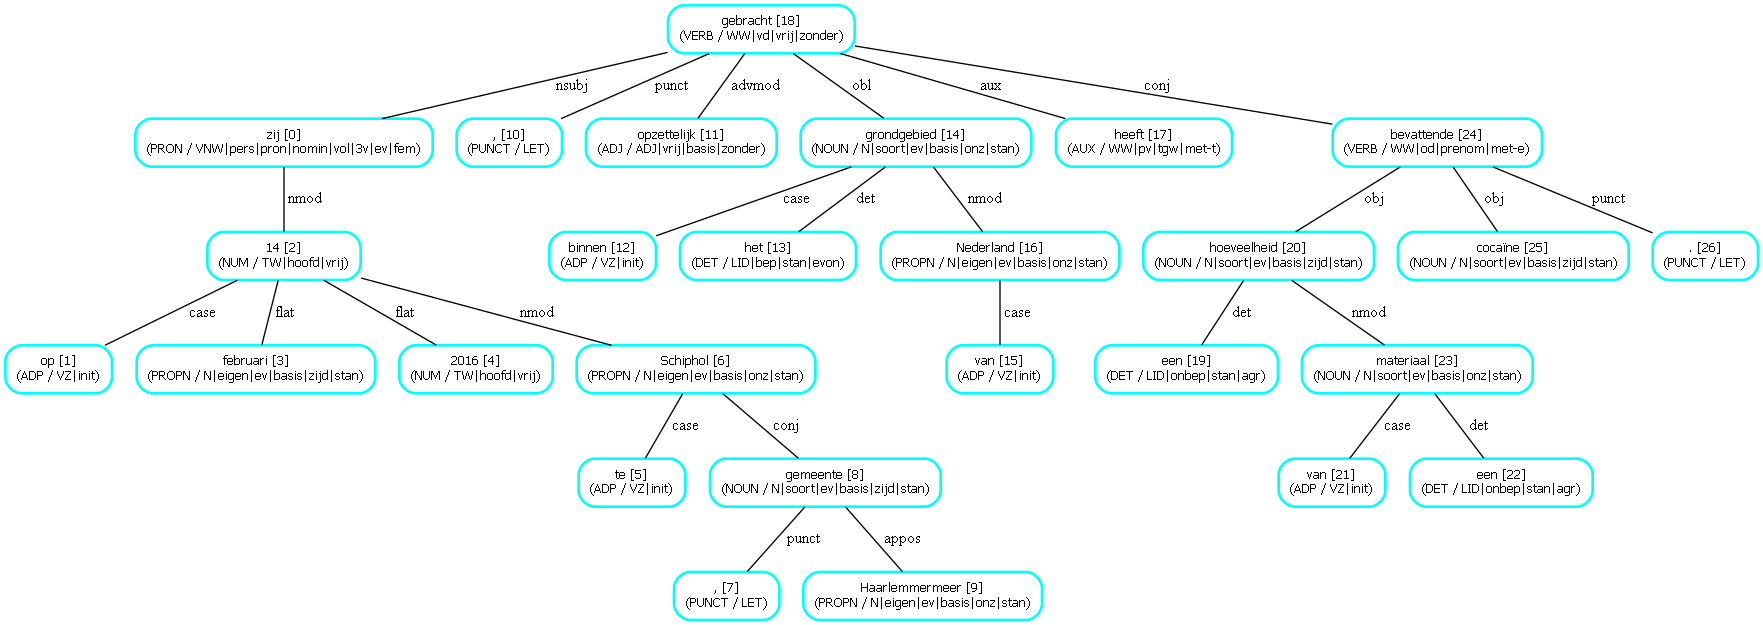

In [178]:
png = visualise_spacy_tree.create_png(nlp(txt))
display(Image(png))